# Ambulance

## Aims:

Compare people who arrived by ambulance to those who did not

Uses full dataset unless stated otherwise (i.e. just restricted by number of admissions - and not by whether arrived within 4 hours of known stroke onset).

<mark>currently exploratory... will need to go through, choose best visualisations, and check I am including all the variables I should be</mark>

**Including relationships over time since the proportion arriving by ambulance changed so much over time**

## Set up

In [1]:
# Import packages and functions
from dataclasses import dataclass
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

# Set max rows when display dataframe
pd.set_option('display.max_rows', 100)

# Linting
%load_ext pycodestyle_magic
%pycodestyle_on

In [2]:
# Set paths and filenames
@dataclass(frozen=True)
class Paths:
    '''Singleton object for storing paths to data and files.'''

    data_path = './../output/'
    admission_only_filename = 'reformatted_data_admissions_only.csv'


paths = Paths()

In [3]:
# Load data
data_full = pd.read_csv(os.path.join(
    paths.data_path, paths.admission_only_filename))

## Reformat data

Drop the few patients who are missing data on whether they arrived by ambulance.

In [4]:
data_full = data_full[data_full['arrive_by_ambulance'].notna()]

Create columns with month and year, or quarter and year.

<mark> would be simpler to make changes to one then create data 4h</mark>

In [5]:
# Create datetime with month and year
data_full['month_year_dt'] = pd.to_datetime(
    data_full['year'].astype(str) + '-' +
    data_full['month'].astype(str), format='%Y-%m')

# Convert to period of m (month and year)
data_full['month_year'] = data_full['month_year_dt'].dt.to_period('m')

# Convert to period of q (quarter and year)
data_full['quarter_year'] = data_full['month_year_dt'].dt.to_period('q')

Add stroke severity groups

In [6]:
conditions = [(data_full['stroke_severity'] == 0),
              (data_full['stroke_severity'].isin(np.arange(1, 5))),
              (data_full['stroke_severity'].isin(np.arange(5, 16))),
              (data_full['stroke_severity'].isin(np.arange(16, 21))),
              (data_full['stroke_severity'].isin(np.arange(21, 43)))]
nihss_choices = ['A: 0', 'B: 1-4', 'C: 5-15', 'D: 16-20', 'E: 21-42']
data_full['stroke_severity_groups'] = np.select(conditions, nihss_choices)

Creating dataframe with just patients who arrived within 4 hours of known onset

In [7]:
data_4h = data_full[(data_full['onset_known'] == 1) &
                    (data_full['onset_to_arrival_time'] <= 4*60)]

## Functions

In [8]:
def proportion_arrivals(group, xlab, ax, dataset=data_full):
    '''
    Plot the proportion of patients arriving by ambulance in
    the specified groups of patients
    group: string, with categories to find proportions in
    xlab: string, x axis label
    ax: axis object to plot on
    dataset: dataframe to use, default is data_full
    '''
    # Find proportions
    df = dataset.groupby(group)['arrive_by_ambulance'].mean()

    # Create line plot
    df.plot(kind='line', marker='o', markersize=2, ax=ax)
    ax.set_xlabel(xlab)
    ax.set_ylabel('Proportion of patients\narriving by ambulance')
    ax.set_title('Proportion of patients arriving by ambulance\n' +
                 'for each ' + xlab.lower(), fontsize=10)


def proportions_by_arrival(col, xlab, ax, bin_pos=0,
                           alt_med='No', alt_bins='No', dataset=data_full):
    '''
    Plots the proportions of patients in the specified columns categories,
    from a dataset split into whether arrived by ambulance or not. Creates
    overlaid histograms with a median line for each.
    col: string, groups of interest
    xlab: string, label for x axis (also used for title)
    ax: axis object to plot on
    bin_pos: number, optional, to modify bin positioning
    alt_med: string, optional, if alternative column for median calculation
    (if providing different columns due to pre-processing/bin locations)
    alt_bins: array, optional, if want alternative binning method
    dataset: dataframe to use, default is data_full
    '''
    # Seperate ambulance and non-ambulance and find medians
    amb = dataset['arrive_by_ambulance'] == 1
    amb_df = dataset.loc[amb, col]
    non_df = dataset.loc[~amb, col]
    if alt_med == 'No':
        amb_med = amb_df.median()
        non_med = non_df.median()
    else:
        amb_med = dataset.loc[amb, alt_med].median()
        non_med = dataset.loc[~amb, alt_med].median()

    # Define bins
    if alt_bins == 'No':
        unique = len(dataset[col].unique())
        bins = np.sort(dataset[col].unique())
        bins = np.append(bins, bins.max() + bins[1] - bins[0])
    else:
        bins = alt_bins

    # Plot overlaid histograms
    ax.hist(non_df, bins, weights=np.ones(len(non_df))/len(non_df),
            alpha=0.5, label='No')
    ax.hist(amb_df, bins, weights=np.ones(len(amb_df))/len(amb_df),
            alpha=0.5, label='Yes')

    # Add median lines
    ax.axvline(non_med, color='C0', linestyle='dashed', alpha=0.65)
    ax.axvline(amb_med, color='orange', linestyle='dashed', alpha=0.65)

    # Add legend, labels and titles
    order = [1, 0]
    ax.legend(title='Ambulance', loc='center left', bbox_to_anchor=(1, 0.5))
    ax.set_xlabel(xlab)
    ax.set_ylabel('Proportion')
    ax.set_title('Proportion of patients of each ' + xlab.lower() + '\n' +
                 'when grouped by whether they arrived by ambulance\n' +
                 '(with line for median ' + xlab.lower() + ')', fontsize=10)


def mean_over_time(col, xlab, ax, dataset=data_full):
    '''
    Plot the mean of the column over time (month+year), when data is grouped
    by whether arrived by ambulance
    col: string, column of interest
    xlab: string, x axis label
    ax: axis object to plot on
    dataset: dataframe to use, default is data_full
    '''
    # Seperate by whether arrived by ambulance
    amb = dataset['arrive_by_ambulance'] == 1
    amb_df = dataset.loc[amb]
    non_df = dataset.loc[~amb]

    # Find mean of col in each month for ambulance v.s. non-ambulance patients
    non_plt = non_df.groupby('month_year')[col].mean()
    amb_plt = amb_df.groupby('month_year')[col].mean()

    non_plt.plot(kind='line', ax=ax, marker='o', markersize=2, label='No')
    amb_plt.plot(kind='line', ax=ax, marker='o', markersize=2, label='Yes')

    plt.ylabel('Mean ' + xlab)
    plt.title('Mean ' + xlab + ' over time by ambulance arrival', fontsize=10)
    plt.legend(title='Ambulance')

## Frequency of ambulance arrivals

Observations:
* Overall **79% patients arrived by ambulance**.
* **Proportion of arrivals by ambulance is decreasing** - it was decreasing from 2016 to 2020, then increased with the first COVID-19 lockdown, and decreased over 2021 (duplicates analysis from comparison over time notebook).

,index,n,percent
0,1.0,283190,78.910484
1,0.0,75685,21.089516


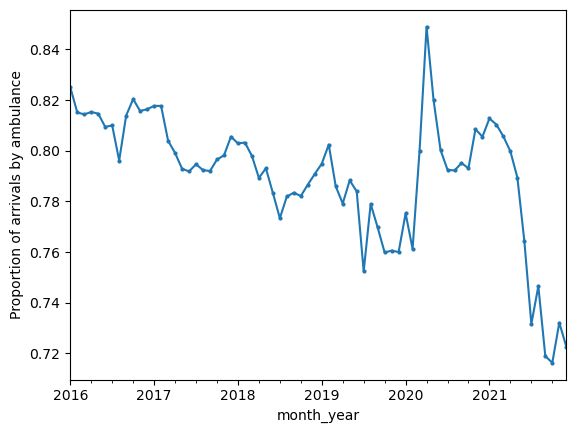

In [9]:
# Find overall frequency
freq = data_full['arrive_by_ambulance'].value_counts().reset_index(name='n')
freq['percent'] = freq['n']/freq['n'].sum()*100
display(freq)

# Plot frequency over time (grouped by month)
df = data_full.groupby('month_year')['arrive_by_ambulance'].mean()
df.plot(kind='line', marker='o', markersize=2)
plt.ylabel('Proportion of arrivals by ambulance')
plt.show()

## Characteristics of patients who arrive by ambulance v.s. not

### Stroke severity

Observations:
* At greater stroke severities, a higher proportion of patients arrive by ambulance.
* From apx. NIHSS 0 to 10 the proportion increases before plateuing around NIHSS 10-15, where the proportion is roughly 95%+.
* Relatedly, patients arriving by ambulance typically had more severe strokes.

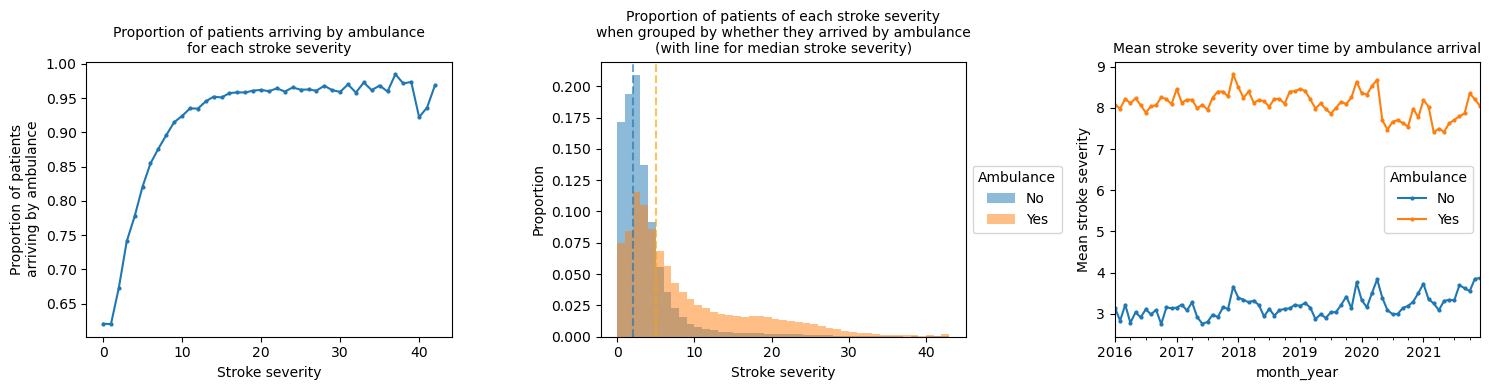

In [10]:
# Set up figure
fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(15, 4))

# Create plots
proportion_arrivals('stroke_severity', 'Stroke severity', ax=ax[0])
proportions_by_arrival('stroke_severity', 'Stroke severity', ax=ax[1])
mean_over_time('stroke_severity', 'stroke severity', ax=ax[2])

# Show plots
plt.tight_layout()
plt.show()

### Age

Observations:
* In higher age groups, a greater proportion of patients arriving by ambulance
* Relatedly, the average age of patients arriving by ambulance was older.

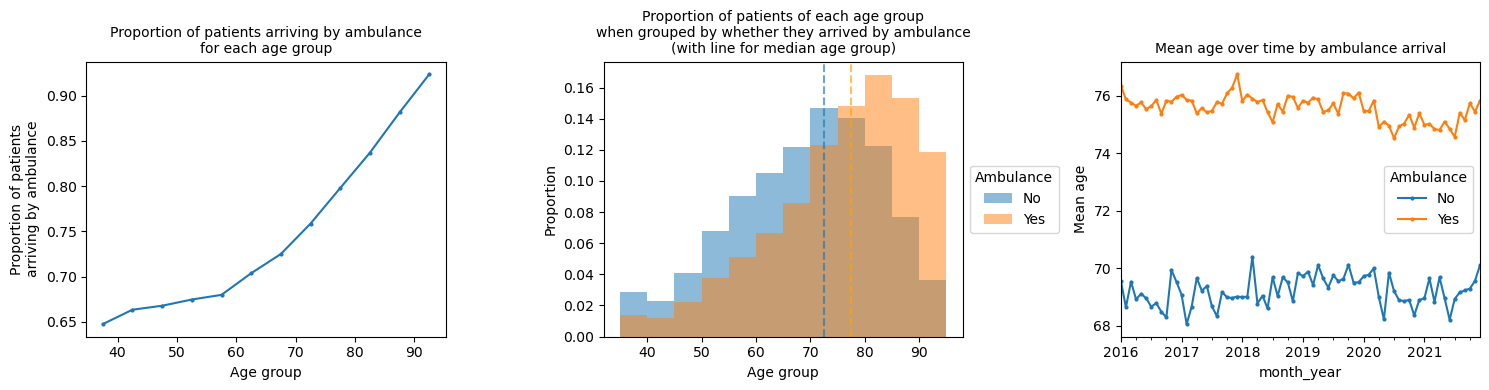

In [11]:
# Set up figure
fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(15, 4))

# Create column where age is the base of the category
data_full['age_base'] = data_full['age'] - 2.5

# Create plots
proportion_arrivals('age', 'Age group', ax=ax[0])
proportions_by_arrival('age_base', 'Age group', ax=ax[1], alt_med='age')
mean_over_time('age', 'age', ax=ax[2])

# Show plots
plt.tight_layout()
plt.show()

### Discharge disability

<mark>overlaid hist is incorrect for this data type - should be bar chart</mark>

Observations:
* Proportion arriving by ambulance increases with discharge disability
* Relatedly, average discharge disability of patients who arrived by ambulance is higher
* Mean discharge disability of patients arriving by ambulance has seasonal variation but no clear overall trend - whilst the mean of patients who do not arrive by ambulance appears to be gradually increasing over time

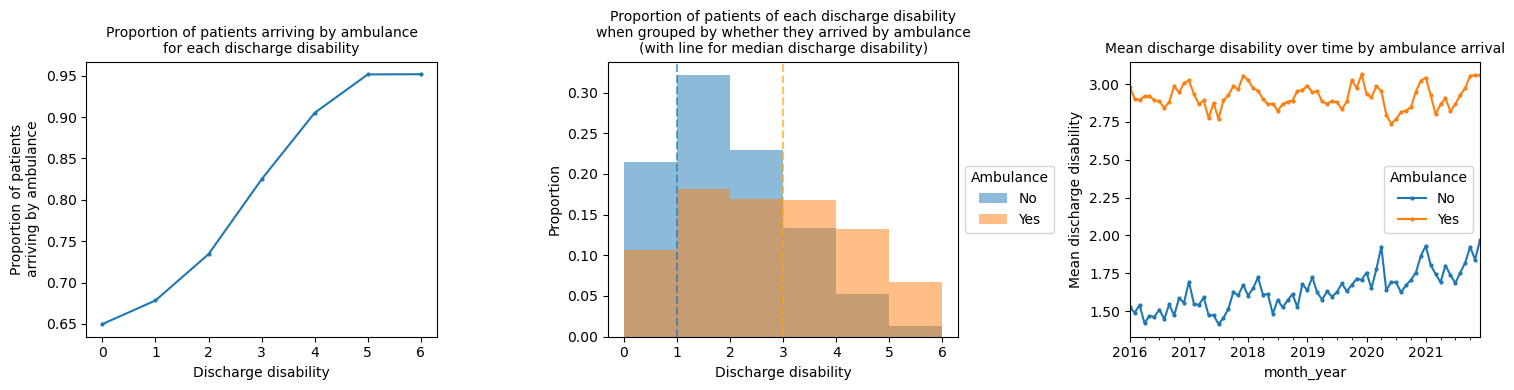

In [12]:
# Set up figure
fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(15, 4))

# Create plots
proportion_arrivals('discharge_disability',
                    'Discharge disability', ax=ax[0])
proportions_by_arrival('discharge_disability',
                       'Discharge disability', ax=ax[1])
mean_over_time('discharge_disability', 'discharge disability', ax=ax[2])

# Show plots
plt.tight_layout()
plt.show()

### Prior disability

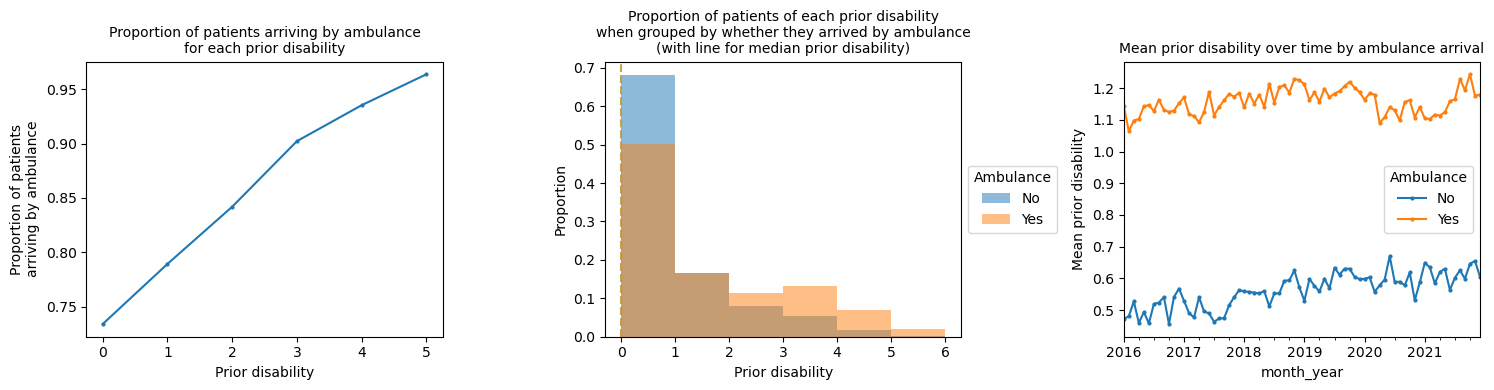

In [13]:
# Set up figure
fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(15, 4))

# Create plots
proportion_arrivals('prior_disability', 'Prior disability', ax=ax[0])
proportions_by_arrival('prior_disability', 'Prior disability', ax=ax[1])
mean_over_time('prior_disability', 'prior disability', ax=ax[2])

# Show plots
plt.tight_layout()
plt.show()

### Disability at 6 months

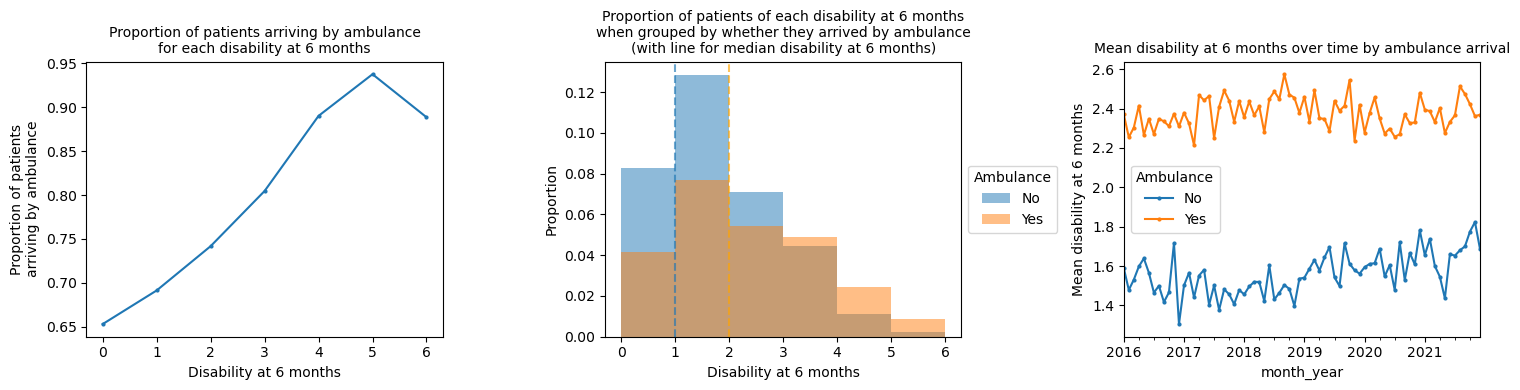

In [14]:
# Set up figure
fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(15, 4))

# Create plots
proportion_arrivals('disability_6_month', 'Disability at 6 months', ax=ax[0])
proportions_by_arrival('disability_6_month',
                       'Disability at 6 months', ax=ax[1])
mean_over_time('disability_6_month', 'disability at 6 months', ax=ax[2])

# Show plots
plt.tight_layout()
plt.show()

### Thrombolysis

<mark>graphs and titles not suitable</mark>

Observations:
* Greater proportion of thrombolysed patients arrive by ambulance
* Relatedly, greater proportion of patients who arrived by ambulance are thrombolysed
* The proportion of ambulance arrivals thrombolysed since early 2020 appears to have decreased, whilst the proportion of non-ambulance arrivals thrombolysed appears to have increased... although you see this less when looking at proportion thrombolysed who those with known onset who arrived within four hours

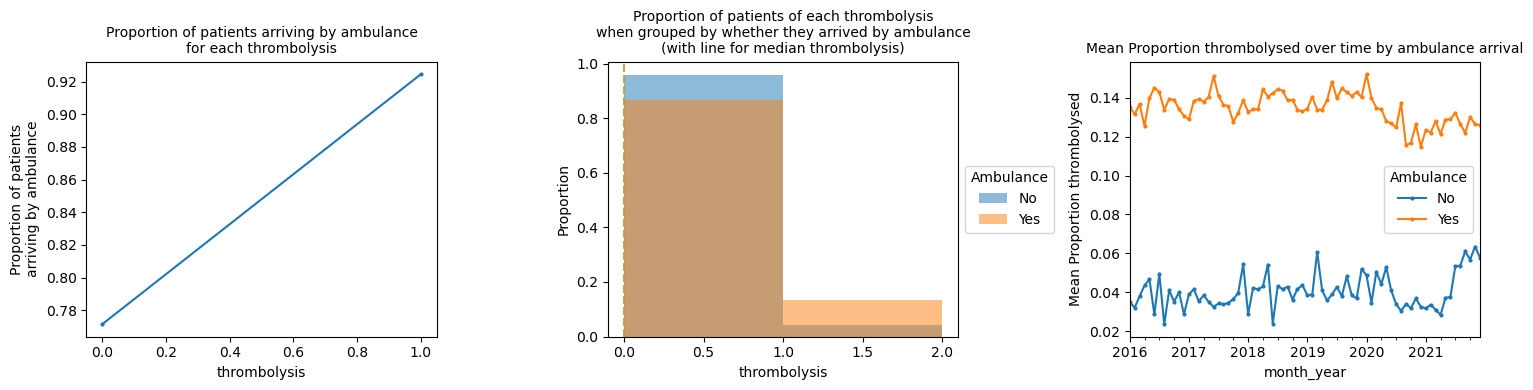

In [15]:
# Set up figure
fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(15, 4))

# Create plots
proportion_arrivals('thrombolysis', 'thrombolysis', ax=ax[0])
proportions_by_arrival('thrombolysis', 'thrombolysis', ax=ax[1])
mean_over_time('thrombolysis', 'Proportion thrombolysed', ax=ax[2])

# Show plots
plt.tight_layout()
plt.show()

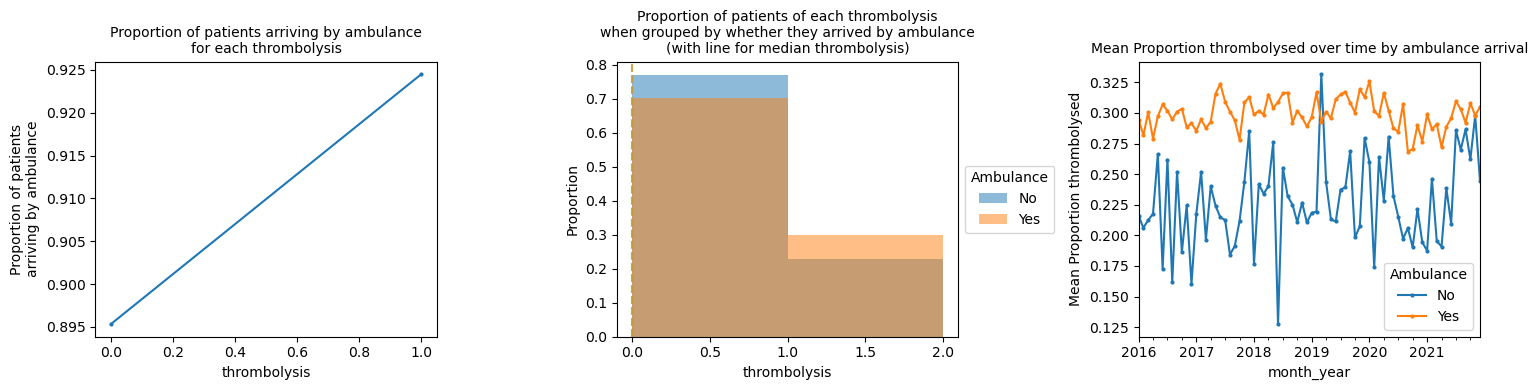

6:80: E501 line too long (81 > 79 characters)
7:80: E501 line too long (84 > 79 characters)


In [16]:
# Set up figure
fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(15, 4))

# Create plots
proportion_arrivals('thrombolysis', 'thrombolysis', ax=ax[0], dataset=data_4h)
proportions_by_arrival('thrombolysis', 'thrombolysis', ax=ax[1], dataset=data_4h)
mean_over_time('thrombolysis', 'Proportion thrombolysed', ax=ax[2], dataset=data_4h)

# Show plots
plt.tight_layout()
plt.show()

### Times

<mark> to do </mark>

<mark> A bit unclear when have median and then mean</mark>

<mark> Make plot on left by binning the dataset </mark>

/tmp/ipykernel_24030/2792475860.py:48: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if alt_bins == 'No':


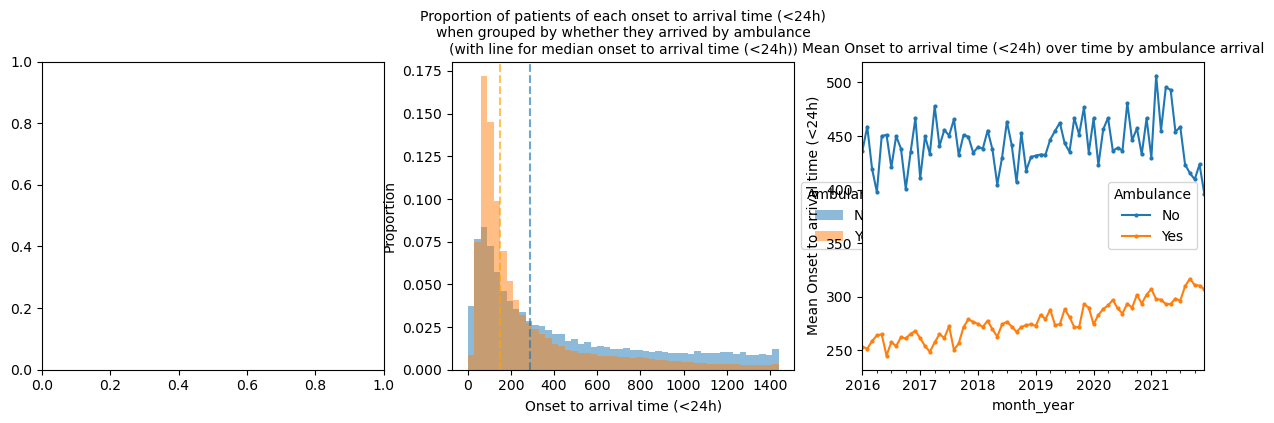

14:80: E501 line too long (101 > 79 characters)


In [17]:
# Ignore times over 24 hours
max = 24*60
onset_data = data_full[data_full['onset_to_arrival_time'] <= max]

# Set up figure
fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(15, 4))

# Distribution of onset to arrival time
proportions_by_arrival(
    'onset_to_arrival_time', 'Onset to arrival time (<24h)', ax=ax[1],
    alt_bins=np.arange(0, max+30, 30), dataset=onset_data)

# Mean time, over the years
mean_over_time('onset_to_arrival_time', 'Onset to arrival time (<24h)', ax=ax[2], dataset=onset_data)

<mark>median then mean then median</mark>

The discrepancy in onset to arrival time by ambulance is more so for lower stroke severities - for the most severe strokes, the average arrival time for ambulance patients was slower.

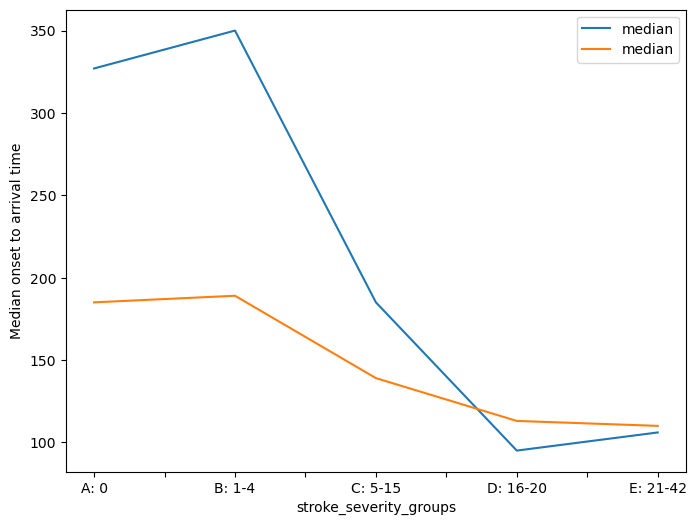

9:80: E501 line too long (85 > 79 characters)


In [18]:
# Median arrival to scan time by stroke severity (groups)
# and whether arrived by ambulance
df = (onset_data
      .groupby(['arrive_by_ambulance',
                'stroke_severity_groups'])['onset_to_arrival_time']
      .median()
      .reset_index(name='median'))
fig, ax = plt.subplots(figsize=(8, 6))
df.groupby('arrive_by_ambulance').plot(x='stroke_severity_groups', y='median', ax=ax)
ax.set_ylabel('Median onset to arrival time')
plt.show()

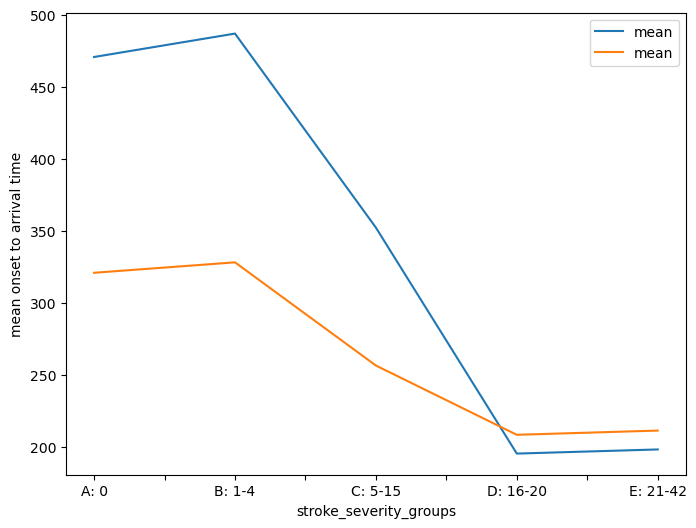

7:80: E501 line too long (83 > 79 characters)


In [19]:
df = (onset_data
      .groupby(['arrive_by_ambulance',
                'stroke_severity_groups'])['onset_to_arrival_time']
      .mean()
      .reset_index(name='mean'))
fig, ax = plt.subplots(figsize=(8, 6))
df.groupby('arrive_by_ambulance').plot(x='stroke_severity_groups', y='mean', ax=ax)
ax.set_ylabel('mean onset to arrival time')
plt.show()

/tmp/ipykernel_24030/2792475860.py:48: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if alt_bins == 'No':


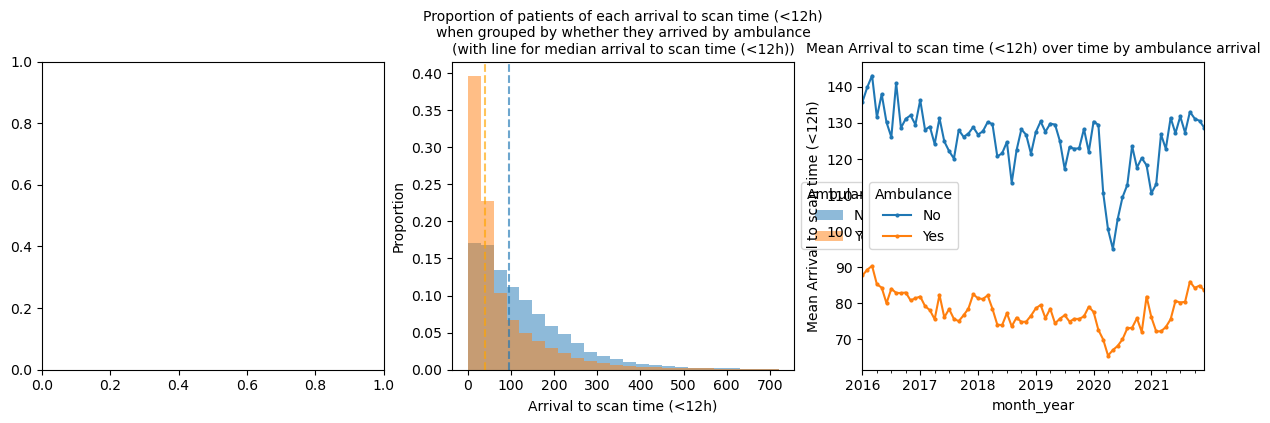

14:80: E501 line too long (99 > 79 characters)


In [20]:
# Ignore times over 24 hours
max = 12*60
onset_data = data_full[data_full['arrival_to_scan_time'] <= max]

# Set up figure
fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(15, 4))

# Distribution of onset to arrival time
proportions_by_arrival(
    'arrival_to_scan_time', 'Arrival to scan time (<12h)', ax=ax[1],
    alt_bins=np.arange(0, max+30, 30), dataset=onset_data)

# Mean time, over the years
mean_over_time('arrival_to_scan_time', 'Arrival to scan time (<12h)', ax=ax[2], dataset=onset_data)

The discrepancy in arrival to scan times by ambulance arrival is more so for lower stroke severities

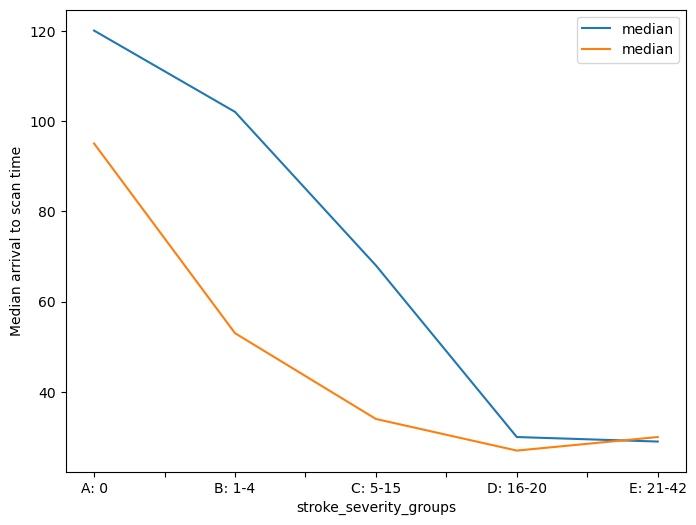

9:80: E501 line too long (85 > 79 characters)


In [21]:
# Median arrival to scan time by stroke severity (groups)
# and whether arrived by ambulance
df = (onset_data
      .groupby(['arrive_by_ambulance',
                'stroke_severity_groups'])['arrival_to_scan_time']
      .median()
      .reset_index(name='median'))
fig, ax = plt.subplots(figsize=(8, 6))
df.groupby('arrive_by_ambulance').plot(x='stroke_severity_groups', y='median', ax=ax)
ax.set_ylabel('Median arrival to scan time')
plt.show()

/tmp/ipykernel_24030/2792475860.py:48: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if alt_bins == 'No':


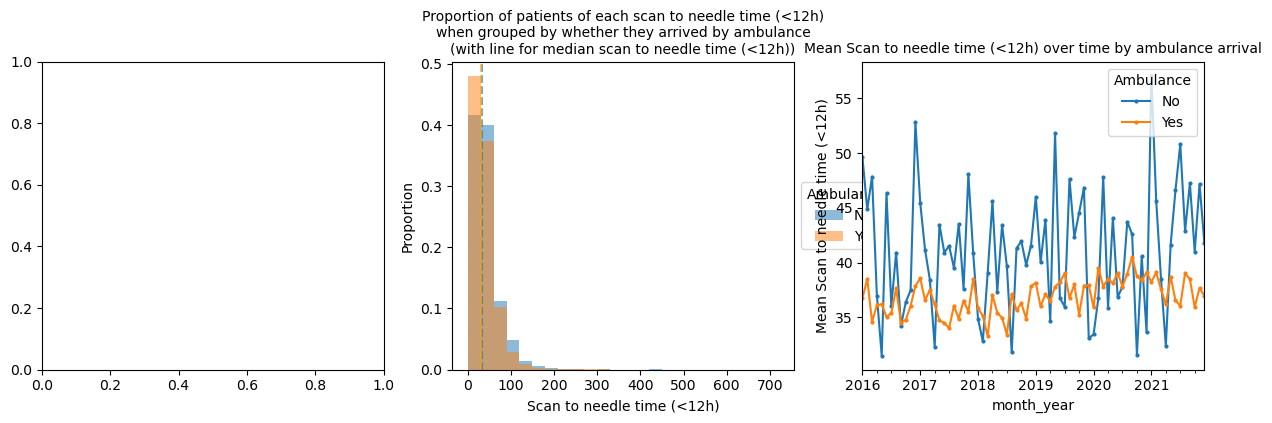

14:80: E501 line too long (103 > 79 characters)


In [22]:
# Ignore times over 24 hours
max = 12*60
onset_data = data_full[data_full['scan_to_thrombolysis_time'] <= max]

# Set up figure
fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(15, 4))

# Distribution of onset to arrival time
proportions_by_arrival(
    'scan_to_thrombolysis_time', 'Scan to needle time (<12h)', ax=ax[1],
    alt_bins=np.arange(0, max+30, 30), dataset=onset_data)

# Mean time, over the years
mean_over_time('scan_to_thrombolysis_time', 'Scan to needle time (<12h)', ax=ax[2], dataset=onset_data)